In [11]:
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode="human")
	
observation,info = env.reset()

In [12]:
# define membership functions
def trapMem(x, params):
    mem = []
    a,b,c,d = np.r_[params]
    for val in x:
        if (a != b):
            term1 = (val - a) / (b - a)
        else:
            term1 = 1
        if (c != d):
            term2 = (d - val) / (d - c)
        else: 
            term2 = 1
        if (a - 0.00001 <= val <= d + 0.00001):
            value = max(min(term1, term2, 1), 0)
        else:
            value = 0
        mem.append(value)
        # print(val, value)
    return mem

def gaussMem(x, params):
    mem = []
    sigma, c = np.r_[params]
    for val in x:
        term1 = -1 * ((val - c) ** 2)
        term2 = 2 * (sigma ** 2)
        value = np.e ** (term1 / term2)
        mem.append(value)
        # print(val, value)
    return mem

def trigMem(x, params):
    mem = []
    a,b,c = np.r_[params]
    for val in x:
        if (a != b):
            term1 = (val - a) / (b - a)
        else:
            term1 = 1
        if (b != c):
            term2 = (c - val) / (c - b)
        else:
            term2 = 1
        if(val < a - 0.00001 or val > c + 0.00001):
            value = 0
        else:
            value = max(min(term1,term2), 0)
        mem.append(value)
        # print(val, value)
    return mem

def centroidDF(x, mf):
    sum = np.sum(mf)
    mfSum = np.sum(np.multiply(mf, x))
    return mfSum / sum

def imp_zadeh(x,y):
    return np.fmin( 1.0 , 1.0 - x + y )

def imp_cor_min(x,y):
    return np.fmin( x, y )

def imp_cor_prod(x,y):
    return np.multiply(x, y)

def implication(x,y,type):
    if (type == 0):
        return np.fmin(1.0, 1.0 - x + y)
    elif (type == 1):
        return np.fmin(x, y)
    elif (type == 2):
        return np.multiply(x, y)

# interpret membership
def interpMem(values, memFunc, x):
    lIndex = None
    for i in range(len(values)):
        if values[i] > x:
            lIndex = i - 1
            break
    
    if lIndex is None: #if the index is at the end of the array
        lIndex = len(values) - 2 # set to the second to last index 

    left = memFunc[lIndex]
    right = memFunc[lIndex + 1]

    leftWeight = (values[lIndex + 1] - x) / (values[lIndex + 1] - values[lIndex])
    rightWeight = 1 - leftWeight

    return (leftWeight * left) + (rightWeight * right)
    
def aggregate(rules, type):
    if (type == 0):
        return np.fmax.reduce(rules)
    if (type == 1):
        return sum(rules)

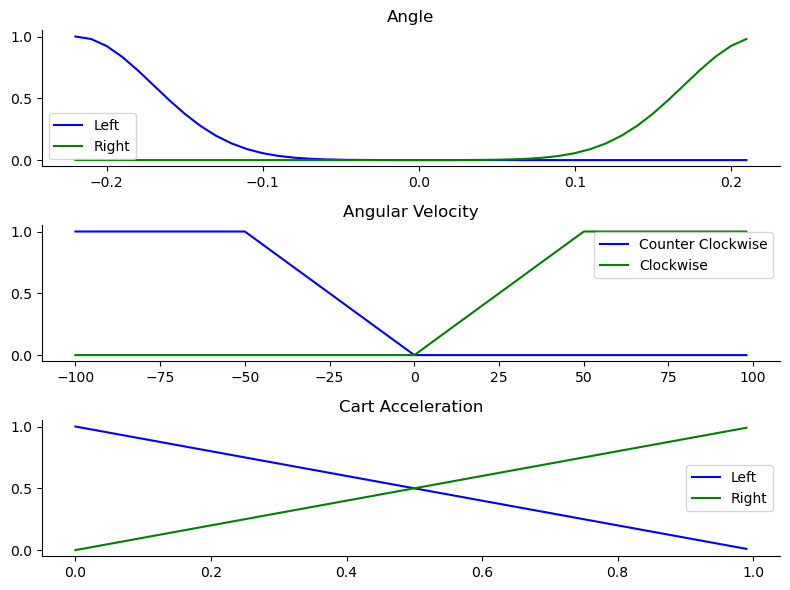

In [13]:
angle = np.arange(-0.22, 0.22, 0.01) #radians
vel = np.arange(-100, 100, 2) #radians per second

angle_left = gaussMem(angle, [0.05, -0.22])
angle_right = gaussMem(angle, [0.05, 0.22])

vel_ccw = trapMem(vel, [-100, -100, -50, 0])
vel_cw = trapMem(vel, [0, 50, 100, 100])


accel = np.arange(0, 1, 0.01) #abstracted to 0 for left, 1 for right

accel_left = trigMem(accel, [0, 0, 1])
accel_right = trigMem(accel, [0, 1, 1])


# visualize these universes and membership functions
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 6))

ax0.plot(angle, angle_left, 'b', linewidth=1.5, label='Left')
ax0.plot(angle, angle_right, 'g', linewidth=1.5, label='Right')
ax0.set_title('Angle')
ax0.legend()

ax1.plot(vel, vel_ccw, 'b', linewidth=1.5, label='Counter Clockwise')
ax1.plot(vel, vel_cw, 'g', linewidth=1.5, label='Clockwise')
ax1.set_title('Angular Velocity')
ax1.legend()

ax2.plot(accel, accel_left, 'b', linewidth=1.5, label='Left')
ax2.plot(accel, accel_right, 'g', linewidth=1.5, label='Right')
ax2.set_title('Cart Acceleration')
ax2.legend()

# turn off top/right axes
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

In [14]:
def cartFIS(observation):
    oPos, oPVel, oAngle, oAVel = np.r_[observation]

    angle_level_l = interpMem(angle, angle_left, oAngle)
    angle_level_r = interpMem(angle, angle_right, oAngle)

    vel_level_cw = interpMem(vel, vel_cw, oAVel)
    vel_level_ccw = interpMem(vel, vel_ccw, oAVel)

    impOp = 2
    aggOp = 0

    rules = []

    rules.append(implication(angle_level_l, accel_left, impOp))
    rules.append(implication(angle_level_r, accel_right, impOp))

    rules.append(implication(vel_level_ccw, accel_left, impOp))
    rules.append(implication(vel_level_cw, accel_right, impOp))

    aggregated = aggregate(rules, aggOp)

    acceleration = centroidDF(accel, aggregated)
    # print(acceleration)
    return acceleration
    

In [15]:
# simulate the environment
episodeNumber=1000
 
counter = 0

for episodeIndex in range(episodeNumber):
    counter += 1
    action = round(cartFIS(observation))
    observation, reward, terminated, truncated, info = env.step(action)
    # print(observation)
    if terminated or truncated:
        print("failed at step", counter)
        print(observation)
        print(action)
        observation, info = env.reset()
        counter = 0
env.close()   

failed at step 500
[-0.3958917  -0.04346298 -0.00544489  0.00039933]
0
failed at step 500
[ 1.9628096e+00  1.6300818e-03 -6.4659570e-03  2.9458404e-01]
0
